In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained('./lowest_loss')
tokenizer = AutoTokenizer.from_pretrained('./model')


In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
def test_loaded_model(text,model=model):
    inputs = tokenizer(text, return_tensors="pt")
    inputs.to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        return model.config.id2label[predicted_class_id]

In [4]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [5]:
test_loaded_model("Hezké jméno! Tak ať se mu daří :)")

'LABEL_1'

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict
from torch import tensor
from transformers import ElectraTokenizer,ElectraModel, ElectraForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split

data = pd.read_csv('./editedlabels.csv',index_col=0)

In [7]:
train_data, val_data = train_test_split(data, test_size=0.4)
model_path="./model"

test_raw = Dataset.from_pandas(val_data)
def preprocess_function(examples):
    encoded_inputs = tokenizer(examples['text'], padding="max_length", truncation=True,max_length=64)
    input_ids = encoded_inputs.input_ids
    attention_mask = encoded_inputs.attention_mask
    labels = examples['label']
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}
test_processed = test_raw.map(preprocess_function, batched=True)

Map:   0%|          | 0/3501 [00:00<?, ? examples/s]

In [8]:
from transformers import Trainer, TrainingArguments
from datasets import load_metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    accuracy = load_metric("accuracy")
    f1 = load_metric("f1")
    precision = load_metric("precision")
    recall = load_metric("recall")
    
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average='weighted')
    prec = precision.compute(predictions=predictions, references=labels, average='weighted')
    rec = recall.compute(predictions=predictions, references=labels, average='weighted')
    
    return {
        "accuracy": acc['accuracy'],
        "f1": f1_score['f1'],
        "precision": prec['precision'],
        "recall": rec['recall']
    }

# Setup training arguments, focusing here more on evaluation aspects
args = TrainingArguments(
    output_dir="./outputs",
    per_device_eval_batch_size=64,  # Adjust based on your GPU/CPU and memory availability
    do_train=False,  # We're only doing evaluation
    do_eval=True
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=test_processed,  # Your processed test dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/home/alienware/.local/lib/python3.10/site-packages/accelerate/accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [25]:
# Evaluate the model
evaluation_results = trainer.evaluate()

# Print the results
print(evaluation_results)


  0%|          | 0/42 [00:00<?, ?it/s]

/tmp/ipykernel_37045/2034949918.py:7: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy = load_metric("accuracy")
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric.

/home/alienware/.local/lib/python3.10/site-packages/datasets/load.py:752: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


{'eval_loss': 0.514193058013916, 'eval_accuracy': 0.9287890327494288, 'eval_f1': 0.928644726412948, 'eval_precision': 0.9286845728739047, 'eval_recall': 0.9287890327494288, 'eval_runtime': 4.6513, 'eval_samples_per_second': 564.573, 'eval_steps_per_second': 9.03}


In [9]:
model.config

ElectraConfig {
  "_name_or_path": "./lowest_loss",
  "architectures": [
    "ElectraForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.36.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 3052

In [10]:
# Model config settings
# model.config
id2label = {0: "NEGATIVE", 1: "POSITIVE", 2: "NEUTRAL"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1, "NEUTRAL": 2}


model.config.id2label = id2label
model.config.label2id = label2id

In [11]:
test_loaded_model("Hezké jméno! Tak ať se mu daří :)")

'POSITIVE'

In [12]:
# get predictions for prediction_comments

prediction_data = pd.read_csv('prediction_comments.txt', sep='\t', header=None, names=['text'])

In [13]:
# lazy way
# data['predicted_label'] = data['text'].map(test_loaded_model)
prediction_data['predicted_label'] = prediction_data['text'].map(test_loaded_model)

In [14]:
prediction_data

,text,predicted_label
NaN,"To už tu bylo, z 5 na 20%. Všichni si přidali ...",NEUTRAL
NaN,v tomhle vedru bych bral i studenou vodu :D,NEUTRAL
NaN,taky dobry... ja jsem se slevomatem skoncila.,NEUTRAL
NaN,Dobrý den. Chci se zeptat jestli by jste mi zj...,NEUTRAL
NaN,"máte zde být od 8 -20 hod - jakto , že nikdo n...",NEUTRAL
...,...,...
NaN,no a zamestnanci si to vychutnavaji jak na ser...,POSITIVE
NaN,měla jsem ji 2x a opravdu krásně voní,POSITIVE
NaN,"Dobry den, negativni prispevky misto reakce ma...",NEUTRAL
NaN,no k Evženovi by měl přibýt Hugo a Bonifác ;),NEUTRAL


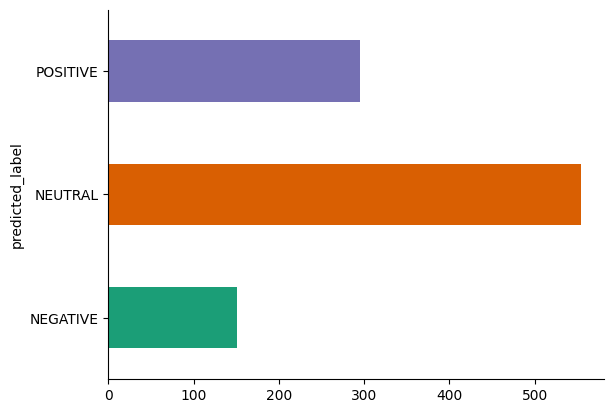

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
prediction_data.groupby('predicted_label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [16]:
# save predicted texts
prediction_data.to_csv('predicted_comments_with_prediction_labels.csv', index=False)

In [17]:
testloadeddata = pd.read_csv('predicted_comments_with_prediction_labels.csv')

In [18]:
testloadeddata

,text,predicted_label
0,"To už tu bylo, z 5 na 20%. Všichni si přidali ...",NEUTRAL
1,v tomhle vedru bych bral i studenou vodu :D,NEUTRAL
2,taky dobry... ja jsem se slevomatem skoncila.,NEUTRAL
3,Dobrý den. Chci se zeptat jestli by jste mi zj...,NEUTRAL
4,"máte zde být od 8 -20 hod - jakto , že nikdo n...",NEUTRAL
...,...,...
995,no a zamestnanci si to vychutnavaji jak na ser...,POSITIVE
996,měla jsem ji 2x a opravdu krásně voní,POSITIVE
997,"Dobry den, negativni prispevky misto reakce ma...",NEUTRAL
998,no k Evženovi by měl přibýt Hugo a Bonifác ;),NEUTRAL
